## Initial Imports

In [92]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.kinetics import Kinetics400

from IPython.display import Video
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Path.ls = lambda x: [o.name for o in x.iterdir()]

### Video Transformations from [`pytorch/vision/references/video_classification/transforms.py` ](https://github.com/pytorch/vision/blob/master/references/video_classification/transforms.py)

In [474]:
import torch
import random


def crop(vid, i, j, h, w):
    return vid[..., i:(i + h), j:(j + w)]


def center_crop(vid, output_size):
    h, w = vid.shape[-2:]
    th, tw = output_size

    i = int(round((h - th) / 2.))
    j = int(round((w - tw) / 2.))
    return crop(vid, i, j, th, tw)


def hflip(vid):
    return vid.flip(dims=(-1,))


# NOTE: for those functions, which generally expect mini-batches, we keep them
# as non-minibatch so that they are applied as if they were 4d (thus image).
# this way, we only apply the transformation in the spatial domain
def resize(vid, size, interpolation='bilinear'):
    # NOTE: using bilinear interpolation because we don't work on minibatches
    # at this level
    scale = None
    if isinstance(size, int):
        scale = float(size) / min(vid.shape[-2:])
        size = None
    return torch.nn.functional.interpolate(
        vid, size=size, scale_factor=scale, mode=interpolation, align_corners=False)


def pad(vid, padding, fill=0, padding_mode="constant"):
    # NOTE: don't want to pad on temporal dimension, so let as non-batch
    # (4d) before padding. This works as expected
    return torch.nn.functional.pad(vid, padding, value=fill, mode=padding_mode)


def to_normalized_float_tensor(vid):
    return vid.permute(3, 0, 1, 2).to(torch.float32) / 255


def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std


# Class interface

class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    @staticmethod
    def get_params(vid, output_size):
        """Get parameters for ``crop`` for a random crop.
        """
        h, w = vid.shape[-2:]
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w
        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, vid):
        i, j, h, w = self.get_params(vid, self.size)
        return crop(vid, i, j, h, w)


class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, vid):
        return center_crop(vid, self.size)


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, vid):
        return resize(vid, self.size)


class ToFloatTensorInZeroOne(object):
    def __call__(self, vid):
        return to_normalized_float_tensor(vid)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, vid):
        return normalize(vid, self.mean, self.std)


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, vid):
        if random.random() < self.p:
            return hflip(vid)
        return vid


class Pad(object):
    def __init__(self, padding, fill=0):
        self.padding = padding
        self.fill = fill

    def __call__(self, vid):
        return pad(vid, self.padding, self.fill)


### .

## Data Loading

In [3]:
base_dir = Path('/Users/rahulsomani/01_github_projects/video-classification/')
data_dir = base_dir/'data'

In [4]:
!tree {data_dir/'train'}

/Users/rahulsomani/01_github_projects/video-classification/data/train
├── class1
│   ├── c1-sample1.mp4
│   └── c1-sample2.mp4
└── class2
    ├── c2-sample1.mp4
    └── c2-sample2.mp4

2 directories, 4 files


In [5]:
data = Kinetics400(data_dir/'train',
                   step_between_clips = 1,
                   extensions         = ('mp4',),
                   frames_per_clip    = 32,
                   frame_rate = None)

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


In [6]:
data[0][0].shape

/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torchvision-0.5.0a0+5eee011-py3.7-macosx-10.7-x86_64.egg/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.


torch.Size([32, 900, 1600, 3])

## Seeing the Data to Understand What Exactly is in the Training Data

### Helper Functions

In [7]:
def get_metadata(data):
    """
    Takes in a `Kinetics400` dataset, computes the no. of frames in each data point
    and returns in a DataFrame
    """
    fnames     = [f.rsplit('/')[-1] for f in data.metadata['video_paths']]
    num_frames = [len(pts) for pts in data.metadata['video_pts']]
    fps        = [i for i in data.metadata['video_fps']]

    metadata = pd.DataFrame(list(zip(fnames, num_frames, fps)), columns = ['Filename', '# Frames', 'FPS'])
    return metadata

In [8]:
def plot_img(sub_plt, x, i):
    """
    Where `x` is one data sample of shape `(T, H, W, C)` and
    `i` is the index of `T` that must be plotted.
    `sub_plt` is an `AxesSubplot`.
    This function removes axes labels and ticks, and names the
    subplot with the appropriate frame number
    """
    sub_plt.imshow(x[i])
    sub_plt.set_title(f'Frame #{i+1}')
    sub_plt.axis('off')

In [340]:
def plot_adjacent(x, figsize=(8,5), i1=0, i2=31):
    f, plots = plt.subplots(1, 2, figsize=figsize)
    plots[0] = plot_img(plots[0], x, i1)
    plots[1] = plot_img(plots[1], x, i2)

    f.tight_layout()

### Seeing the Training Data

<br>
When the dataset of class `Kinetics400` is constructed with `frames_per_clip = 32`, it doesn't take into consideration any data points which have less than 32 clips. <br>

As seen in the DataFrame above, `c2-sample1` and `c2-sample2` had less than 32 frames, and `[len(x) for x in data.video_clips.clips]` reveals that 0 samples were taken from both these clips. 

For `c1-sample1`, which has exactly 32 clips, one clip gets created, whereas for `c1-sample2`, 16 clips get created, leading to a dataset of `len = 17`. The dataset has 1 sample from `c1-sample1` and 16 samples from `c1-sample2`.

<br>

In [10]:
get_metadata(data)

,Filename,# Frames,FPS
0,c1-sample1.mp4,32,25.0
1,c1-sample2.mp4,47,25.0
2,c2-sample1.mp4,17,25.0
3,c2-sample2.mp4,13,25.0


In [11]:
len(data)

17

In [12]:
[len(x) for x in data.video_clips.clips]

[1, 16, 0, 0]

---
<h3> Below are the actual videos

In [13]:
Video('../data/train/class1/c1-sample1.mp4', width=400)

In [14]:
Video('../data/train/class1/c1-sample2.mp4', width=400)

In [15]:
Video('../data/train/class2/c2-sample1.mp4', width=400)

In [16]:
Video('../data/train/class2/c2-sample2.mp4', width=400)

<br>

To fully understand what's happening, look at the first and last frames of selected data samples (indices 0, 1, 2 and 16) below.

<br>

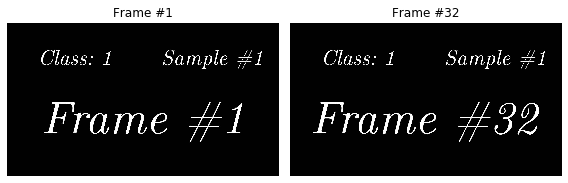

In [17]:
plot_adjacent(data[0][0])

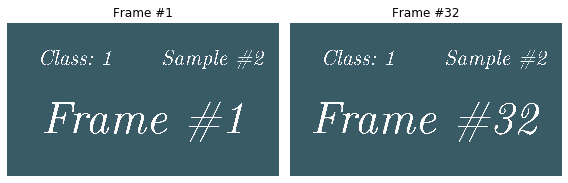

In [18]:
plot_adjacent(data[1][0])

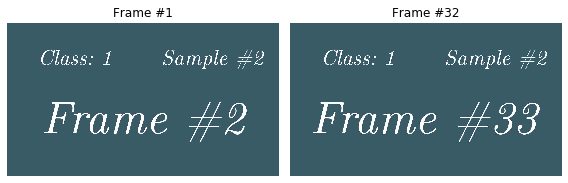

In [19]:
plot_adjacent(data[2][0])

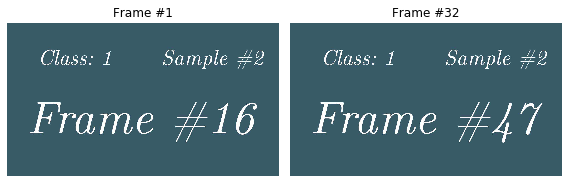

In [20]:
plot_adjacent(data[16][0])

<br>

---

## Data Augmentations -- Albumentations

In [21]:
import os
import numpy as np
from skimage.color import label2rgb

import albumentations as A
import random

### Read Video as `Torch Tensor`

This isn't nearly as efficient as `torchvision`'s video reader but is useful to quickly read in a video as a `torch.Tensor` for experiments.

In [151]:
file = '/Users/rahulsomani/01_github_projects/video-classification/data/train/class1/c1-sample1.mp4'

In [307]:
def read_video_tensor(file):
    import ffmpeg

    out, _ = (
        ffmpeg
        .input(file)
        .output('pipe:', format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True)
    )

    meta = ffmpeg.probe(file)['streams'][0]
    height, width = meta['height'], meta['width']

    vid = (
        np
        .frombuffer(out, np.uint8)
        .reshape([-1, height, width, 3])
    )

    return torch.from_numpy(vid)

In [310]:
vid = read_video_tensor(file)
vid.shape

torch.Size([32, 900, 1600, 3])

### Albumentations on a Single Frame

<br>

`x` is one data sample i.e. a `tensor` of 32 frames/images. To apply albumentations, we'll first apply it on one single frame, then loop and apply over all the frames. As seen below, _not all_ `albumentations` can be applied to `torch.Tensor`s, so they first need to be converted to `np.array`. However, this is a good thing because the `albumentations` always work faster on `np.array` vs. `torch.Tensor`

In [81]:
x = data[3][0]
x.shape

torch.Size([32, 900, 1600, 3])

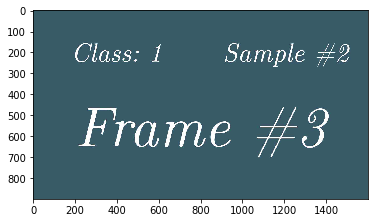

In [44]:
plt.imshow(x[0])

In [311]:
def show(aug, img):
    img = aug(image = img)['image']
    plt.figure(figsize=(6,6))
    plt.imshow(img)

CPU times: user 70.9 ms, sys: 12.5 ms, total: 83.3 ms
Wall time: 87.1 ms


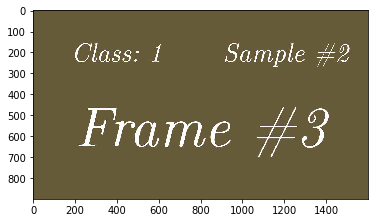

In [312]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), np.asarray(x[0]))

In [313]:
for i in x: print(i.shape)

torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])


CPU times: user 105 ms, sys: 5.33 ms, total: 111 ms
Wall time: 122 ms


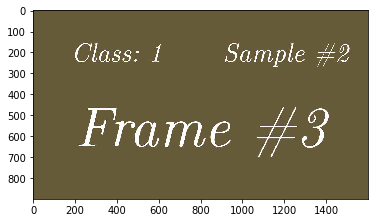

In [314]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), x[0])

CPU times: user 63.9 ms, sys: 2.36 ms, total: 66.3 ms
Wall time: 66.7 ms


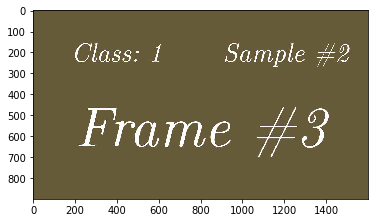

In [315]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), np.asarray(x[0]))

In [317]:
%%time

random.seed(42)
show(A.ToGray(p=1), x[0])

TypeError: Expected Ptr<cv::UMat> for argument '%s'

CPU times: user 69.2 ms, sys: 3.45 ms, total: 72.6 ms
Wall time: 82 ms


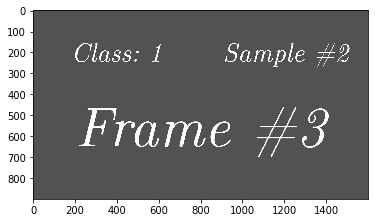

In [318]:
%%time

random.seed(42)
show(A.ToGray(p=1), np.asarray(x[0]))

### Albumentations on a Video i.e. List of Frames

<br>

Here, I define a function `aug_video` which applies a list of `albumentations` to a video. It ensures that the exact same transformation is applied to each frame of the video. This is a must because, for instance, you wouldn't want one frame of the video to be horizontally flipped while the next not. This is done using a constant `random.seed()` value.

In [325]:
file = '/Users/rahulsomani/Desktop/tennis-dataset-1-minimal/train/forehand/point#1_shot#2_David_Ferrer_-_Best-Ever_Roadrunner_Points.mp4'

In [324]:
out, _ = (
    ffmpeg
    .input(file)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)

meta = ffmpeg.probe(file)['streams'][1]
height, width = meta['height'], meta['width']

vid = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

In [326]:
vid.shape

(42, 1080, 1920, 3)

In [417]:
tfms = A.Compose([
    A.HorizontalFlip(p=0.0),
    #A.ToGray(p=1),
    #A.CLAHE(p=1),
    A.Cutout(p=1),
    #A.RandomRain(p=1),
    #A.ChannelDropout(p=1),
    #A.ChannelShuffle(p=1),
    A.InvertImg(p=1)
])

In [418]:
def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid))

torch.Size([42, 1080, 1920, 3])

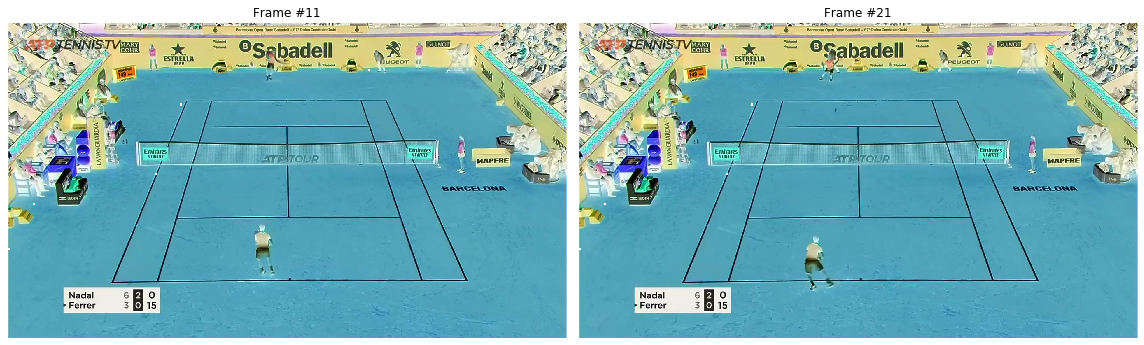

In [419]:
vidaug = (aug_video(vid, tfms))
vidaug.shape
plot_adjacent(vidaug, figsize=(16, 9), i1=10, i2=20)

In [420]:
vid.shape

(42, 1080, 1920, 3)

In [ ]:
ToFloatTensorInZeroOne

### Testing to see if the `ToFloatTensorInZeroOne` and `Normalize` from the torchvision Video Transforms can be incorporated in the same `Compose` list as `albumentations`


In [481]:
tmp = torch.from_numpy(vid)
tmp.shape

torch.Size([42, 1080, 1920, 3])

In [411]:
to_normalized_float_tensor(tmp).shape

torch.Size([3, 42, 1080, 1920])

In [413]:
tmp.shape[-2:]

torch.Size([1920, 3])

In [428]:
def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std

mean = [0.43216, 0.394666, 0.37645]
std  = [0.22803, 0.22145, 0.216989]

In [431]:
shape = (-1,) + (1,) * (tmp.dim() - 1)
shape

(-1, 1, 1, 1)

In [440]:
torch.as_tensor(mean).shape

torch.Size([3])

In [451]:
# in the official code
(torch.as_tensor(mean).reshape(shape)).shape

torch.Size([3, 1, 1, 1])

In [452]:
# recreating to see if same result can be optained with `C` axis at end instead of beginning
torch.as_tensor(mean)[..., None, None, None].shape

torch.Size([3, 1, 1, 1])

In [453]:
torch.as_tensor(mean)[None, None, None].shape

torch.Size([1, 1, 1, 3])

In [463]:
raw_shape = (tmp/255. - torch.as_tensor(mean)[None, None, None])
raw_shape.shape

torch.Size([42, 1080, 1920, 3])

In [459]:
test_target = to_normalized_float_tensor(tmp) - torch.as_tensor(mean).reshape(shape)
test_target.shape

torch.Size([3, 42, 1080, 1920])

In [464]:
to_normalized_float_tensor(raw_shape).shape == test_target.shape

True

In [465]:
to_normalized_float_tensor(raw_shape) == test_target

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

---

### Combining Torchvision Normalising and Albumentations

<br>

**They can't** be combined in one `Compose`(or it's too painful to make it happen). <br>
Instead, in the following chunk of `__getitem__` function of `Kinetics400`...

```python
if self.transform is not None:
    video = self.transform(video) 
```

... we can pass in only the normalisation functions, and then add another line to call the `albumentations` transformations, like so:

```python
if self.transform is not None:
    video = self.transform(video) # Torchvision `ToFloatTensorInZeroOne` and `Normalize`. Returns shape (C,T,H,W)
    video = self.tfms_albumentations(video) # Albumentations Transforms
```

In order to do so, we'll need to tweak the `aug_video` function defined in the above section to `permute` to the appropriate shape `(T,H,W,C)`, and after the `albumentations` transforms are done, `permute` back to shape `(C,T,H,W)`

In [483]:
tfms_torch = torchvision.transforms.Compose([
    ToFloatTensorInZeroOne(),
    Normalize(mean=[0.43216, 0.394666, 0.37645],
              std=[0.22803, 0.22145, 0.216989])
])

In [484]:
tfms_torch(vidaug).shape

torch.Size([3, 42, 1080, 1920])

In [485]:
tfms_torch(vidaug).permute(1,2,3,0).shape

torch.Size([42, 1080, 1920, 3])

Redefine `aug_video` for combining both kinds of transformations -- accomodate changin

In [522]:
def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    vid = vid.permute(1,2,3,0) # added line of code
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid)).permute(3,0,1,2)

In [536]:
def combine_tfms(vid, tfms_torch, tfms_albu):
    if not isinstance(vid, torch.Tensor): vid = torch.from_numpy(vid)
    return aug_video(tfms_torch(vid), tfms_albu)

In [523]:
tfms_albu = A.Compose([
    A.HorizontalFlip(p=1),
    A.ChannelShuffle(p=1)
])

In [537]:
vid.shape

(42, 1080, 1920, 3)

In [538]:
combined = combine_tfms(vid, tfms_torch, tfms_albu)
combined.shape

torch.Size([3, 42, 1080, 1920])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


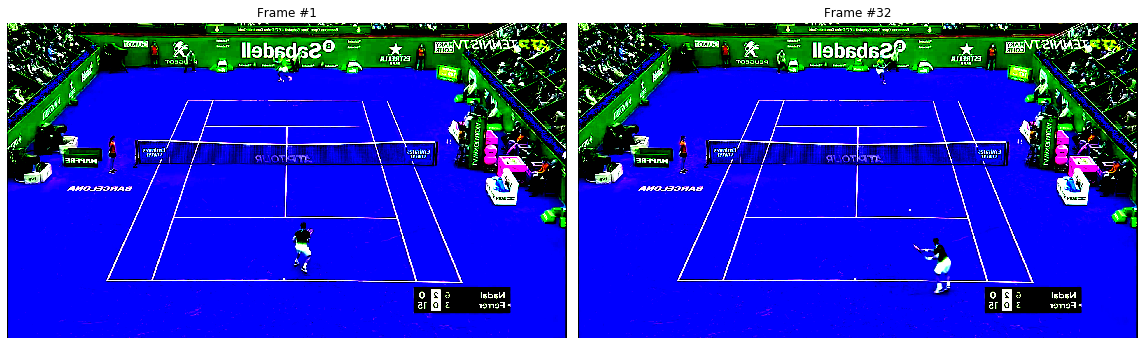

In [539]:
plot_adjacent(combined.permute(1,2,3,0), figsize=(16,10))

## Figuring out by Experimenting

In [21]:
from torchvision.datasets.video_utils import *

In [22]:
x_pts = data.video_clips.video_pts[1]
x_pts

tensor([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
        10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000,
        20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000,
        30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000,
        40000, 41000, 42000, 43000, 44000, 45000, 46000])

In [23]:
x_fps = data.video_clips.video_fps[1]
x_fps

25.0

In [24]:
fr = data.video_clips.frame_rate
fr

In [25]:
clips, idxs = VideoClips.compute_clips_for_video(
    video_pts  = x_pts,
    num_frames = 16,
    step = 1,
    fps  = x_fps,
    frame_rate = fr)

In [26]:
len(clips)

32

In [27]:
tmp = [len(v) for v in clips]
tmp

[16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16]

In [28]:
torch.as_tensor(tmp).cumsum(0).tolist()

[16,
 32,
 48,
 64,
 80,
 96,
 112,
 128,
 144,
 160,
 176,
 192,
 208,
 224,
 240,
 256,
 272,
 288,
 304,
 320,
 336,
 352,
 368,
 384,
 400,
 416,
 432,
 448,
 464,
 480,
 496,
 512]

In [29]:
data.video_clips.cumulative_sizes

[1, 17, 17, 17]

In [30]:
data.video_clips.clips

[tensor([[    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000,
          20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000,
          30000, 31000]]),
 tensor([[    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000,
          20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000,
          30000, 31000],
         [ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000, 10000,
          11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000,
          21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000,
          31000, 32000],
         [ 2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000, 10000, 11000,
          12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000,
          22000, 23000, 24000, 25000, 26000

In [31]:
torch.as_tensor([len(v) for v in data.video_clips.clips])

tensor([ 1, 16,  0,  0])